In [1]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# MAX_STEPS = 512
# class GymnasiumEnv(gym.Env):
#     def __init__(self, grid_size=20, obs_size=5, num_agents=8, num_targets=6):
#         super(GymnasiumEnv, self).__init__()

#         self.info_grid_size = grid_size
#         self.obs_size = obs_size
#         self.num_agents = num_agents
#         self.num_targets = num_targets
#         self.info_grid = np.zeros((grid_size, grid_size))
#         self.agent_pos = self.reset_agent_positions()  # Random initial agent positions
#         self.targets = self.generate_targets()
#         self.agent_grid = [np.zeros((grid_size, grid_size)) for _ in range(self.num_agents)]
#         self.action_space = spaces.Discrete(5)  # Five discrete actions: up, down, left, right, stay
#         self.observation_space = spaces.Box(low=0, high=1, shape=(obs_size, obs_size), dtype=np.float32)
#         self.step_counter = 0
#         # self.normalize_info()
#         self.reset()

#     def reset_agent_positions(self):
#         return [(np.random.randint(self.info_grid_size), np.random.randint(self.info_grid_size)) for _ in range(self.num_agents)]

#     def generate_targets(self):
#         return [(np.random.randint(self.info_grid_size), np.random.randint(self.info_grid_size)) for _ in range(self.num_targets)]

#     def generate_gaussians(self):
#         # Reset grid to zero before adding Gaussian distributions
#         self.info_grid = np.zeros((self.info_grid_size, self.info_grid_size))
#         for target_pos in self.targets:
#             mean_x, mean_y = target_pos
#             # Ensure sigma is not too large
#             sigma = np.random.uniform(1, min(self.info_grid_size // 2, 10))
#             x, y = np.meshgrid(np.arange(self.info_grid_size), np.arange(self.info_grid_size))
#             # Calculate the Gaussian distribution
#             gaussian = np.exp(-((x - mean_x)**2 + (y - mean_y)**2) / (2 * sigma**2))
#             # Normalize the Gaussian distribution so that the maximum value is 1
#             gaussian /= gaussian.max()
#             # Add the Gaussian distribution to the grid
#             self.info_grid += gaussian
#         # Normalize the grid values to the range [0, 1]
#         self.info_grid /= self.info_grid.max()

#     def step(self, actions):
#         self.step_counter += 1
#         states = []
#         rewards = [0] * self.num_agents
#         dones = [False] * self.num_agents
#         temp = self.info_grid.copy()

#         if self.step_counter >= MAX_STEPS:  # Define MAX_STEPS as the threshold
#             return states, rewards, [True] * self.num_agents, {} 

#         for agent_id, action in enumerate(actions):
#             x, y = self.agent_pos[agent_id]
#             new_pos = self.update_agent_position(x, y, action)
#             self.agent_pos[agent_id] = new_pos
#             self.update_gaussian(new_pos)  # Update Gaussian distribution after reaching a target
#             if new_pos in self.targets:
#                 rewards[agent_id] = np.sum(temp - self.info_grid)
#                 dones[agent_id] = True
#                 self.targets.remove(new_pos)
#                 self.agent_grid[agent_id][new_pos[0], new_pos[1]] = 1  # Update agent grid at new position

#                 # Share and update agent_grid with other agents if mutual target positions exist
#                 for other_agent_id in range(self.num_agents):
#                     if other_agent_id != agent_id and np.any(self.agent_grid[agent_id] * self.agent_grid[other_agent_id] > 0):
#                         mutual_targets = np.where(self.agent_grid[agent_id] * self.agent_grid[other_agent_id] > 0)
#                         self.agent_grid[other_agent_id][mutual_targets] = 1  # Update mutual target positions

#             self.agent_grid[agent_id] = self.get_agent_views(agent_id)  # Update agent's grid
#             state_1 = self.get_state_1(agent_id)
#             state_2 = self.get_state_2(agent_id)
#             states.append((state_1, state_2))  # Append the state tuple for the agent to states list
#         return states, rewards, dones, {}

#     def update_gaussian(self, new_pos):
#         sigma = 1  # Smaller Gaussian sigma
#         x_min = max(0, new_pos[0]-2)
#         x_max = min(self.info_grid_size, new_pos[0]+3)
#         y_min = max(0, new_pos[1]-2)
#         y_max = min(self.info_grid_size, new_pos[1]+3)
#         x, y = np.meshgrid(np.arange(x_min, x_max), np.arange(y_min, y_max), indexing='ij')
#         smaller_gaussian = np.exp(-((x - new_pos[0])**2 + (y - new_pos[1])**2) / (2 * sigma**2))
#         # print(smaller_gaussian.shape)
#         max_val = np.max(smaller_gaussian)
#         smaller_gaussian /= max_val if max_val > 0 else 1
#         self.info_grid[y_min:y_max, x_min:x_max] = np.clip(self.info_grid[y_min:y_max, x_min:x_max] - (smaller_gaussian.T * 0.8), 0, None) 
#         self.info_grid /= self.info_grid.max()

#     def get_agent_views(self, agent_id):
#         view = np.zeros((self.info_grid_size, self.info_grid_size))  # Adjust size to match info_grid_size
#         x, y = self.agent_pos[agent_id]
#         window = self.info_grid[x - 2:x + 3, y - 2:y + 3]
#         view[x - 2:x + 3, y - 2:y + 3] = window  # Update view with window from info_grid
#         return view

#     def update_agent_position(self, x, y, action):
#         if action == 0:  # Down
#             y = max(0, y - 1)
#         elif action == 1:  # Up
#             y = min(self.info_grid_size - 1, y + 1)
#         elif action == 2:  # Left
#             x = max(0, x - 1)
#         elif action == 3:  # Right
#             x = min(self.info_grid_size - 1, x + 1)
#         return (x, y)
        
#     def get_state_1(self, agent_id):
#         state_1 = np.zeros((self.obs_size, self.obs_size))
#         x, y = self.agent_pos[agent_id]
#         window = self.info_grid[x - 2:x + 3, y - 2:y + 3]
#         state_1[:window.shape[0], :window.shape[1]] = window
#         return state_1

#     def get_state_2(self, agent_id):
#         x, y = self.agent_pos[agent_id]  # Get position of the specified agent
#         rewards_left = len(self.targets)  # Number of targets left is the rewards left
#         return np.array([x, y, self.step_counter, rewards_left])

#     def reset(self):
#         self.agent_pos = self.reset_agent_positions()
#         self.targets = self.generate_targets()
#         self.info_grid = np.zeros((self.info_grid_size, self.info_grid_size))
#         for target in self.targets:
#             self.info_grid[target] = 2  # Mark targets with 2
#         self.generate_gaussians()  # Generate Gaussian distributions around targets
#         for i in range(self.num_agents):
#             self.agent_grid[i] = self.get_agent_views(i)
#         self.step_counter = 0
#         return self.info_grid, self.agent_grid

#     def render(self, mode='human'):
#         plt.figure(figsize=(12, 8))
#         plt.subplot(2, 2, 1)
#         plt.imshow(self.info_grid, cmap='Oranges', origin='lower')
#         plt.colorbar(label='Information Value')
#         plt.title('Main Grid')
#         plt.xlabel('X')
#         plt.ylabel('Y')
#         plt.grid(visible=True, which="major")

#         # Plot targets
#         for target in self.targets:
#             plt.scatter(target[0], target[1], c='r', marker='o', s=20)

#         for agent in self.agent_pos:
#             plt.scatter(agent[0], agent[1], c='b', marker='o', s=20)

#         plt.tight_layout()
#         plt.show()

# env = GymnasiumEnv(grid_size=32, obs_size=5, num_agents=8, num_targets=8)
# grid, agent_views = env.reset()
# env.render()

In [3]:
# actions = [1] * 8  # List of actions
# next_state, rewards, dones, _ = env.step(actions)
# env.render()

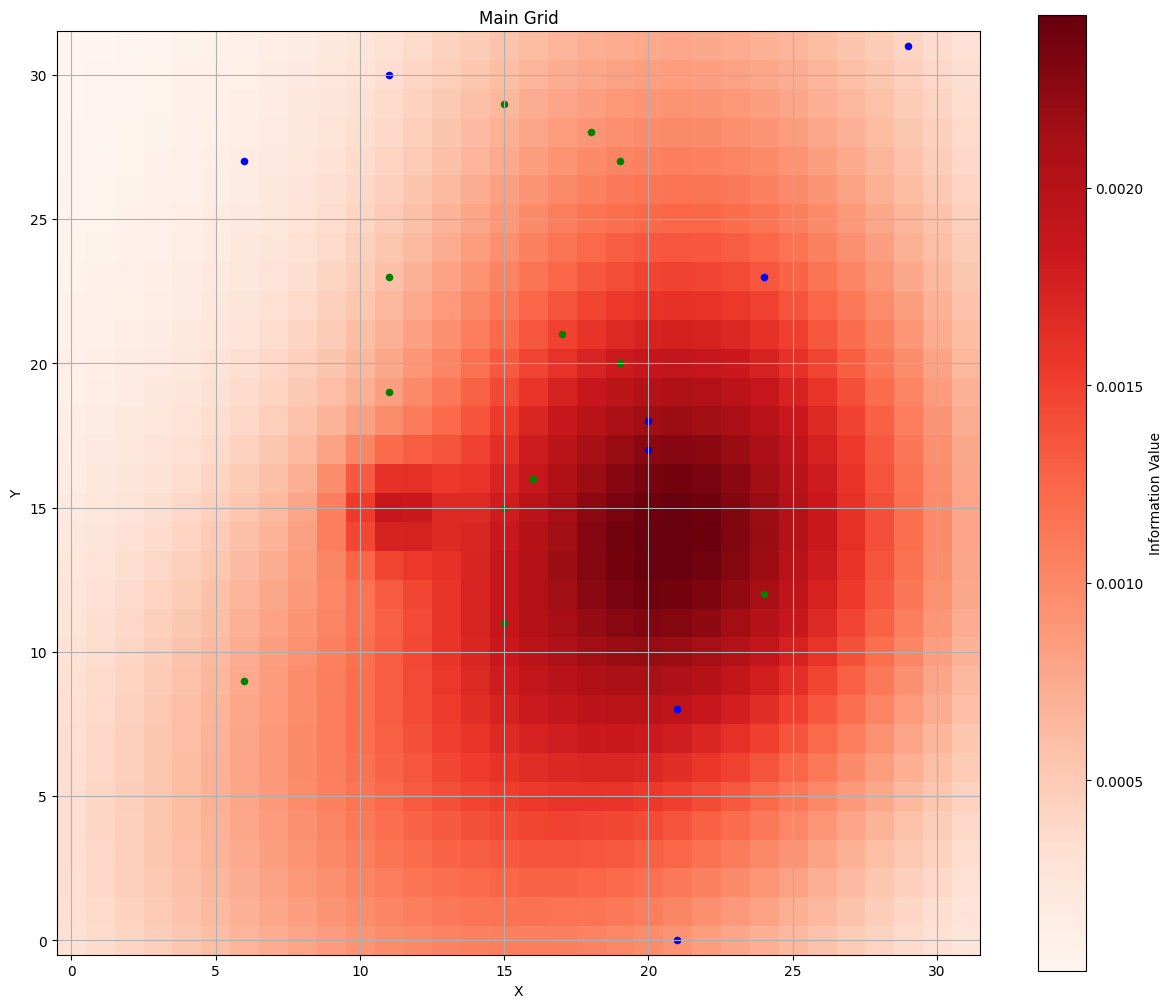

In [6]:
from MAS_Environment import MAS_env

env = MAS_env(grid_size=32,
              obs_size=5,
              num_agents=8,
              num_targets=12)
env.render()


In [ ]:
import time
# Demonstration
for _ in range(5):
    actions = np.random.randint(0, 5, 8)
    next_state, rewards, terminated, truncated, _ = env.step(actions)
    env.render()
    time.sleep(0.5)
    # print(np.asarray(rewards)*1000)

In [35]:
!python3 MAS.py --asynchronous False

Running A2C
Running A2C
  0%|                                                   | 0/200 [00:00<?, ?it/s]Reward: (8,)
Value: torch.Size([8, 1])
Reward: (8,)
Value: torch.Size([8, 1])
Reward: (8,)
Value: torch.Size([8, 1])
Reward: (8,)
Value: torch.Size([8, 1])
Reward: (8,)
Value: torch.Size([8, 1])
Reward: (8,)
Value: torch.Size([8, 1])
Reward: (8,)
Value: torch.Size([8, 1])
Reward: (8,)
Value: torch.Size([8, 1])
Reward: (8,)
Value: torch.Size([8, 1])
Reward: (8,)
Value: torch.Size([8, 1])
Reward: (8,)
Value: torch.Size([8, 1])
Reward: (8,)
Value: torch.Size([8, 1])
Reward: (8,)
Value: torch.Size([8, 1])
Reward: (8,)
Value: torch.Size([8, 1])
Reward: (8,)
Value: torch.Size([8, 1])
Reward: (8,)
Value: torch.Size([8, 1])
Reward: (8,)
Value: torch.Size([8, 1])
Reward: (8,)
Value: torch.Size([8, 1])
Reward: (8,)
Value: torch.Size([8, 1])
Reward: (8,)
Value: torch.Size([8, 1])
Reward: (8,)
Value: torch.Size([8, 1])
Reward: (8,)
Value: torch.Size([8, 1])
Reward: (8,)
Value: torch.Size([8, 1])